In [1]:
import json
import os
import re
import logging
from functools import reduce, partial
from collections import OrderedDict
import pprint
from mkdir_p import mkdir_p

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.model_selection import ParameterGrid

from nnattack.variables import auto_var
from params import (
    compare_attacks,
    compare_defense,
    
    compare_nns,
    nn_k1_robustness,
    nn_k3_robustness,
    
    rf_robustness,
    dt_robustness,
    
    dt_robustness_figs,
    nn_k1_robustness_figs,
    nn_k3_robustness_figs,
    rf_robustness_figs,
    rf_optimality_figs,
    nn_k1_optimality_figs,
    nn_k3_optimality_figs,
)
from utils import set_plot, get_result, write_to_tex, union_param_key, params_to_dataframe

auto_var.set_variable_value('random_seed', 0)
auto_var.set_variable_value('ord', 'inf')
auto_var.set_logging_level(0)

compare_attacks = compare_attacks()
compare_defense = compare_defense()

compare_nns = compare_nns()
nn_k1_robustness = nn_k1_robustness()
nn_k3_robustness = nn_k3_robustness()
rf_robustness = rf_robustness()
dt_robustness = dt_robustness()
dt_robustness_figs = dt_robustness_figs()
nn_k1_robustness_figs = nn_k1_robustness_figs()
nn_k3_robustness_figs = nn_k3_robustness_figs()
rf_optimality_figs = rf_optimality_figs()
nn_k1_optimality_figs = nn_k1_optimality_figs()
nn_k3_optimality_figs = nn_k3_optimality_figs()
rf_robustness_figs = rf_robustness_figs()


Using TensorFlow backend.


In [2]:
def result_latex_figs(exp_name, control_var, caption):
    control = ParameterGrid(control_var)
    ret = """
\\begin{figure}[ht!]
\\centering"""
    img_paths = []
    for i, g in enumerate(control):
        dataset, ord = g['dataset'], g['ord']
        img_path = f'./figs/{exp_name}_{dataset}_{ord}.eps'
        dataset = dataset.replace("_", " ")
        ret += """
\\subfloat[%s]{
    \\includegraphics[width=.45\\textwidth]{%s}}""" % (dataset, img_path)
        if i % 2 == 1:
            ret += "\n"
    ret += """
\\caption{%s}
\\label{fig:%s}
\\end{figure} 
""" % (caption, exp_name)
    return ret
                      
def plot_result(df, exp_name, control_var, variables, get_title=None,
                get_label_name=None, get_label_color=None, show_plot=True):
    for g in ParameterGrid(control_var):
        temp_df = df
                      
        if get_title is None:
            title = exp_name
            for k, v in g.items():
                if v in variable_name[k]:
                    title = title + f"_{variable_name[k][v]}"
                else:
                    title = title + f"_{v}"
        else:
            title = get_title(g)
            
        for k, v in g.items():
            temp_df = temp_df.loc[df[k] == v]
                      
        fig, ax = plt.subplots()
        ax.set_title(title)
        for name, group in temp_df.groupby(variables):
            #print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]
                      
            if get_label_name is not None:
                label = get_label_name(name)
            elif isinstance(name, str):
                if variables[0] not in variable_name:
                    label = name
                elif name in variable_name[variables[0]]:
                    label = variable_name[variables[0]][name]
                else:
                    label = name
            else:
                mod_names = []
                for i, n in enumerate(name):
                    if n in variable_name[variables[i]]:
                        mod_names.append(variable_name[variables[i]][n])
                    else:
                        mod_names.append(n)
                label = mod_name.join("_")

            if get_label_color is not None:
                ax.plot(x, s, label=label, linewidth=2.5, color=get_label_color(name))
            else:
                ax.plot(x, s, label=label, linewidth=2.5)

        dataset = g['dataset']
        ord = g['ord']
        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.png', format='png')
        if show_plot:
            plt.show()
        else:
            plt.close()
                      
variable_name = {
    #'model': {
    #    ''
    #},
    'dataset': {
        r"fashion_mnist35_(?P<samples>\d+)(?P<dims>_pca\d+)?": 'f-mnist35',
        r"fashion_mnist06_(?P<samples>\d+)(?P<dims>_pca\d+)?": 'f-mnist06',
        r"mnist17_(?P<samples>\d+)(?P<dims>_pca\d+)?": 'mnist17',
        r"mnist35_(?P<samples>\d+)(?P<dims>_pca\d+)?": 'mnist35',
        r"digits(?P<dims>_\d+)?": 'digits',
        r"halfmoon_(?P<samples>\d+)": 'halfmoon',
        r"ijcnn1_(?P<samples>\d+)": 'ijcnn',
        
        'abalone': 'abalone',
        'iris': 'iris',
        'wine': 'wine',
        'covtype_3200': 'covtype',
    },
    'attack': {
        'blackbox': 'Cheng\'s',
        'kernelsub_c10000_pgd': 'kernelsub',
        'kernelsub_c1000_pgd': 'kernelsub',
        'rev_nnopt_k1_20': 'nnopt-20-ori',
        'rev_nnopt_k1_50': 'nnopt-50-ori',
        'rev_nnopt_k1_20_region': 'nnopt-20',
        'rev_nnopt_k1_50_region': 'nnopt-50',
        'rev_nnopt_k3_20': 'nnopt-20-ori',
        'rev_nnopt_k3_50': 'nnopt-50-ori',
        'rev_nnopt_k3_20_region': 'nnopt-20',
        'rev_nnopt_k3_50_region': 'nnopt-50',
        'rev_nnopt_k5_20': 'nnopt-20-ori',
        'rev_nnopt_k5_50': 'nnopt-50-ori',
        'rev_nnopt_k5_20_region': 'nnopt-20',
        'rev_nnopt_k5_50_region': 'nnopt-50',
        'rev_nnopt_k7_20': 'nnopt-20-ori',
        'rev_nnopt_k7_50': 'nnopt-50-ori',
        'rev_nnopt_k7_20_region': 'nnopt-20',
        'rev_nnopt_k7_50_region': 'nnopt-50',
        
        'nnopt_k1_all': 'nnopt-all',
        'nnopt_k3_all': 'nnopt-all',
        
        'direct_k1': 'direct attack',
        'direct_k3': 'direct attack',
        'direct_k5': 'direct attack',
        'direct_k7': 'direct attack',
        
        'rf_attack_all': 'RF-all',
        'rf_attack_rev': 'RF-rev',
        'rf_attack_rev_20': 'RF-rev-20',
        'rf_attack_rev_50': 'RF-rev-50',
        'rf_attack_rev_100': 'RF-rev-100',
    },
    'ord': {},
}


In [17]:
def knn_attack_plots(exp_name, grid_param, caption='', show_plot=True):
    df = params_to_dataframe(grid_param)
    datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']

    control = {
        'dataset': datasets,
        'ord': grid_param[0]['ord'],
    }
    variables = ['attack']
    plot_result(df, exp_name, control, variables, show_plot)
    return result_latex_figs(exp_name, control, caption)
    
def get_var_name(var, arg):
    if var == 'model':
        if 'adv' in arg or 'robust' in arg:
            arg = "%s_%02d" % ("_".join(arg.split("_")[:-1]), int(arg.split("_")[-1]))
        else:
            arg = arg
    else:
        arg = variable_name[var].get(arg, arg)
    return arg.replace('_', '-')

def get_var_name(var, arg):
    
    if var == 'dataset':
        for k, v in variable_name['dataset'].items():
            arg = re.sub(k, v, arg)
        return arg
    return arg.replace('_', '-')

def avg_pert_table(exp_name, grid_param, columns, rows, objs:list=None):
    if objs is None:
        objs = ['avg_pert']
    columns = list(filter(lambda a: a not in ['n_features', 'n_samples', 'n_classes'], columns))
    if len(columns) == 0 or len(rows) == 0:
        return pd.DataFrame({})
    df = params_to_dataframe(grid_param, objs)
    
    d = OrderedDict()
    col_grid = OrderedDict([(c, union_param_key(grid_param, c)) for c in columns])
    row_grid = OrderedDict([(r, union_param_key(grid_param, r)) for r in rows])
    for obj in objs:
        temp_df = df.groupby(columns + rows)[obj].mean()
        temp_df_sem = df.groupby(columns + rows)[obj].sem()
        
        if obj == 'tst_score':
            assert columns[0] == 'model'
        for col in ParameterGrid(col_grid):
            col_k = tuple(col[c] for c in columns)
            col_name = tuple([get_var_name(c, col[c]) for c in columns[:-1]] \
                             + ["%s-%s" % (get_var_name(columns[-1], col[columns[-1]]), obj.replace("_", "-"))])
            d[col_name] = {}
            for row in ParameterGrid(row_grid):
                row_k = tuple(row[r] for r in rows)
                row_name = tuple(get_var_name(r, row[r]) for r in rows)
                if (col_k + row_k) in temp_df:
                    #d[col_name][row_name] = "$%.3f \pm %.3f$" % (temp_df[col_k + row_k], temp_df_sem[col_k + row_k])
                    d[col_name][row_name] = "$%.3f$" % (temp_df[col_k + row_k])
                    d[col_name][row_name] = d[col_name][row_name].replace("0.", ".")
                else:
                    d[col_name][row_name] = -1

    #d = OrderedDict([(k, d[k]) for k in d.keys()])
    return pd.DataFrame(d)

def dataset_stat_column(df, grid_param, columns, rows):
    if ("n_features" not in columns) and ("n_samples" not in columns) and ("n_classes" not in columns):
        return df
    
    column_names = {
        'n_features': '\# features',
        'n_samples': '\# examples',
        'n_classes': '\# classes',
    }
    
    d = df.to_dict(into=OrderedDict)
    datasets = union_param_key(grid_param, "dataset")
    if len(d.keys()) > 0:
        first_key = list(d.keys())[0]
        row_len = 1 if isinstance(d[first_key], str) else len(first_key)
        col_len = 1 if isinstance(first_key, str) else len(first_key)
        ori_cols = list(d.keys())
    else:
        row_len = 1
        col_len = 1
        ori_cols = []
    
    for dataset in datasets:
        X, y, _ = auto_var.get_var_with_argument("dataset", dataset)
        row_name = (get_var_name("dataset", dataset), )
        for col in columns:
            if col not in column_names:
                continue
            column_name = tuple(['-' for _ in range(col_len-1)] + [column_names[col]])
            if col == "n_features":
                d.setdefault(column_name, {})[row_name] = X.shape[1]
            elif col == "n_samples":
                d.setdefault(column_name, {})[row_name] = X.shape[0]
            elif col == "n_classes":
                d.setdefault(column_name, {})[row_name] = len(np.unique(y))
                
    for col in ori_cols:
        d.move_to_end(col)
        
    return pd.DataFrame(d)
    
def cmp_ratio(df):
    ret = OrderedDict()
    d = df.to_dict(into=OrderedDict)
    cmp_base = []
    
    i = 0
    for col, col_dict in d.items():
        ret[col] = col_dict
        if 'avg-pert' not in col[1]:
            continue
        if i == 0 or i == 1:
            cmp_base.append(col_dict)
            i += 1
            continue
        temp = {}
        for k, v in col_dict.items():
            if v == -1 or cmp_base[i % 2][k] == -1:
                temp[k] = int(-1)
            else:
                v = v.replace("$", "")
                t = cmp_base[i % 2][k].replace("$", "")
                temp[k] = "$%.2f$" % (float(v) / float(t))
        
        ret[tuple([c for c in col[:-1]] + ["%s imp." % col[-1]])] = temp
        i += 1
        #ret[tuple([c for c in col[:-1]] + ["%d imp." % i])] = temp
        
    return pd.DataFrame(ret)

def max_imp(df):
    ret = OrderedDict()
    d = df.to_dict(into=OrderedDict)
    
    def add_new_col(col_list, ret):
        new_col = {}
        
        for attack_name in [col_list[0][0][1], col_list[1][0][1]]:
            temp = list(filter(lambda t: t[0][1] == attack_name, col_list))
            imps = []
            for c in temp:
                imps.append([float(v.replace("$", "")) if v != -1 else -1 for _, v in c[1].items()])
            imps = (np.array(imps).T).argmax(axis=1)

            new_col = {}
            new_col_imp = {}
            new_col_eps = {}
            pcol = temp[0][0]
            
            if 'd' in pcol[0].split("-")[-1]:
                tt = pcol[0].split("-")
                tt.pop(-2)
            else:
                tt = pcol[0].split("-")[:-1]
            new_col_name = ("-".join(tt), pcol[1])
            new_col_imp_name = ("-".join(tt), ("%s imp." % pcol[1]))
            new_col_eps_name = ("-".join(tt), ("%s $\\epsilon$" % pcol[1]))
            for i, idx in enumerate(imps):
                k, v = list(temp[idx][1].items())[i]
                new_col[k] = v
                k, v = list(temp[idx][2].items())[i]
                new_col_imp[k] = v 

                if 'd' in temp[idx][0][0].split("-")[-1]:
                    new_col_eps[k] = "$" + ("%.1f$" % (float(temp[idx][0][0].split("-")[-2]) * 0.01))[1:]
                else:
                    new_col_eps[k] = "$" + ("%.1f$" % (float(temp[idx][0][0].split("-")[-1]) * 0.01))[1:]

            ret[new_col_eps_name] = new_col_eps
            ret[new_col_name] = new_col
            ret[new_col_imp_name] = new_col_imp
    
    prev_col = None
    temp = []
    for i, (col, col_dict) in enumerate(d.items()):
        if 'd' in col[0].split("-")[-1]:
            check_idx = -2
        else:
            check_idx = -1
            
        if i == 0 or i == 1:
            ret[col] = col_dict
            continue
            
        if len(temp) == 0:
            temp.append(col_dict)
        elif i % 2 == 1:
            temp[-1] = (prev_col, temp[-1], col_dict)
            if i == (len(d.items())-1):
                add_new_col(temp, ret)
        else:
            if col[0].split("-")[:check_idx] != prev_col[0].split("-")[:check_idx]:
                add_new_col(temp, ret)
                temp = [col_dict]
            else:
                temp.append(col_dict)
                
        prev_col = col
        
    return pd.DataFrame(ret)

def table_wrapper(exp_name, grid_params, columns, rows, objs=None, caption="",
                  combine_method=None, additionals=None):
    if objs is None:
        objs = ['avg_pert']
    t = """
\\begin{table}[h!]
\\tiny
\\centering
\\setlength{\\tabcolsep}{2.0pt}
"""
    df = pd.DataFrame({})
    if combine_method is None:
        df = avg_pert_table(exp_name, grid_params, columns, rows, objs)
        if additionals:
            for fn in additionals:
                df = fn(df)
    else:
        dfs = []
        for g in grid_params:
            df = avg_pert_table(exp_name, g, columns, rows, objs)
            if additionals:
                for fn in additionals:
                    df = fn(df)
            dfs.append(df)
        df = pd.concat(dfs, axis=combine_method)
    
    if 'dataset' in rows:
        df = dataset_stat_column(df, grid_param, columns, rows)
    t += df.to_latex(escape=False)
    t += """\\caption{%s}
\\label{table:%s_%s}
\\end{table}
""" % (caption, exp_name, objs[0])
    return t


In [4]:
def model_acc(df, grid_param):
    # col = ['model', 'attack']
    ret = OrderedDict()
    tst_df = params_to_dataframe(grid_param, ['tst_score'])

    d = df.to_dict(into=OrderedDict)
    models = set([c[0] for c, _ in d.items()])
    
    prev_col =None
    for i, (col, col_dict) in enumerate(d.items()):
        new_col_dict = OrderedDict({})
        if i == 0:
            for row, _ in col_dict.items():
                temp_df = tst_df[(tst_df['model'] == col[0].replace("-", "_"))
                                 & (tst_df['attack'] == 'blackbox') 
                                 & (tst_df['dataset'] == row[0].replace("-", "_"))]
                new_col_dict[row] = "$%.2f$" % temp_df['tst_score'].mean()
            ret[(col[0], col[1].replace('-avg-pert', ' tst acc.'))] = new_col_dict
            
        elif '\\epsilon' in col[1]:
            m = re.match(r"(?P<attack>[a-zA-Z_0-9'-]+) \$\\epsilon\$", col[1])
            attack_name = m.group("attack")[:-9].replace("-", "_") # remove '$epsilon$'
            for row, row_val in col_dict.items():
                if 'd' in col[0].split('-')[-1]:
                    model_name = '%s-%d-%s' % ('-'.join(col[0].split('-')[:-1]),
                                               int(float(row_val.replace("$", ""))*100),
                                               col[0].split('-')[-1],)
                else:
                    model_name = "%s-%d" % (col[0], int(float(row_val.replace("$", ""))*100))
                model_name = model_name.replace("-", "_")
                temp_df = tst_df[(tst_df['model'] == model_name)
                                 & (tst_df['attack'] == attack_name) 
                                 & (tst_df['dataset'] == row[0].replace("-", "_"))]
                new_col_dict[row] = "$%.2f$" % temp_df['tst_score'].mean()
            ret[(col[0], col[1].replace('-avg-pert $\\epsilon$', ' tst acc.'))] = new_col_dict
            
        prev_col = col
        ret[col] = col_dict
    return pd.DataFrame(ret)

In [14]:
#_, exp_name, grid_param, _ = nn_k1_robustness()
#params_to_dataframe(grid_param, ['trnX_len', 'aug_len']).groupby(['dataset', 'model'])['aug_len'].mean()

In [6]:
#_, exp_name, grid_param, _ = nn_k1_robustness()
#_, exp_name, grid_param, _ = dt_robustness()
#_, exp_name, grid_param, _ = rf_robustness()
#_, exp_name, grid_param, _ = nn_k3_robustness()
#df = params_to_dataframe(grid_param, ['avg_pert', 'tst_score']).groupby(['dataset', 'model'])
#df.mean()

In [20]:
def improvement(df):
    ret = OrderedDict()
    d = df.to_dict(into=OrderedDict)
    
    for i, (col, col_dict) in enumerate(d.items()):
        ret[col] = {}
        for row, row_value in col_dict.items():
            if i == 0:
                ref = col_dict
                value = 1.0
            elif ref[row] == -1 or row_value == -1:
                value = -1.
            else:
                value = (float(row_value.replace("$", '')) / float(ref[row].replace("$", '')))
                
            ret[col][row] = "$%.2f$" % value
        
    return pd.DataFrame(ret)

_, exp_name, grid_param, _ = compare_defense()
avg_caption = "Average improvement ratio using different defense appraoch acorss classifiers."
table_str = table_wrapper(exp_name, grid_param, ['model', 'attack'], ['dataset'], caption=avg_caption, 
                          combine_method=1,
                          objs=['avg_pert'], additionals=[improvement])
table_str = table_str.replace("                 knn1 &          adv-nn-k1-30 &     robustv1-nn-k1-30",
                              "\multicolumn{3}{c}{1-NN}")
table_str = table_str.replace("                           knn3 &                    adv-nn-k3-30 &               robustv1-nn-k3-30",
                              "\multicolumn{3}{c}{3-NN}")
table_str = table_str.replace("decision-tree-d5 & adv-decision-tree-d5-30 & robust-decision-tree-d5-30 & robustv1-decision-tree-d5-30",
                              "\multicolumn{4}{c}{DT}")
table_str = table_str.replace("      random-forest-100-d5 &           adv-rf-100-30-d5 &        robust-rf-100-30-d5 &      robustv1-rf-100-30-d5",
                              "\multicolumn{4}{c}{RF}")
table_str = table_str.replace("nnopt-k1-all-avg-pert & nnopt-k1-all-avg-pert & nnopt-k1-all-avg-pert",
                              "regular & adv train & adv prune")
table_str = table_str.replace("rev-nnopt-k3-50-region-avg-pert & rev-nnopt-k3-50-region-avg-pert & rev-nnopt-k3-50-region-avg-pert",
                              "regular & adv train & adv prune")
table_str = table_str.replace("dt-attack-opt-avg-pert &  dt-attack-opt-avg-pert &     dt-attack-opt-avg-pert &       dt-attack-opt-avg-pert",
                              "regular & adv train & robust split & adv prune")
table_str = table_str.replace("rf-attack-rev-100-avg-pert & rf-attack-rev-100-avg-pert & rf-attack-rev-100-avg-pert & rf-attack-rev-100-avg-pert",
                              "regular & adv train & robust split & adv prune")
table_str = table_str.replace("adv-nnopt-k1-all-avg-pert", "adv train")
table_str = table_str.replace("robustv1-nn-k1-30", "adv prune")
table_str = table_str.replace("adv-decision-tree-d5-30", "adv train")
table_str = table_str.replace("robustv1-decision-tree-d5-30", "adv prune")
table_str = table_str.replace("lllllllllllllll", "l|ccc|ccc|cccc|cccc")
#for k, v in variable_name['dataset'].items():
#    table_str = re.sub(k.replace('_', '-'), v, table_str)
write_to_tex(table_str, exp_name + '_table.tex')

In [21]:
_, exp_name, grid_param, _ = compare_attacks()
avg_caption = "Average minimum perturbation distance (Linf) acorss classifiers."
table_str = table_wrapper(exp_name, grid_param, ['model', 'attack'], ['dataset'], caption=avg_caption, 
                          combine_method=1,
                          objs=['avg_pert'], additionals=[])
table_str = re.sub(r"([a-zA-Z_0-9'-]+) imp\.", "imp.", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+) tst acc\.", "tst acc.", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+)-avg-pert", r"\1", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+) \$\\epsilon\$", "$\\epsilon$", table_str)
table_str = table_str.replace("lllllllllll", "l|ccc|ccc|cc|cc")
table_str = table_str.replace("-avg-pert", "")
table_str = table_str.replace("direct-k1", "direct")
table_str = table_str.replace("direct-k3", "direct")
table_str = table_str.replace("nnopt-k1-all", "opt")
table_str = table_str.replace("rev-nnopt-k3-50-region", "our's")
table_str = table_str.replace("rf-attack-rev-100", "our's")
table_str = table_str.replace("dt-attack-opt", "opt")
table_str = table_str.replace("decision-tree-d5", "DT")
table_str = table_str.replace("random-forest-100-d5", "RF")
table_str = table_str.replace("knn1", "1-NN")
table_str = table_str.replace("knn3", "3-NN")
table_str = table_str.replace("\multicolumn{3}{l}", "\multicolumn{3}{c}")
table_str = table_str.replace("\multicolumn{2}{l}", "\multicolumn{2}{c}")
table_str = table_str.replace("blackbox", "Cheng's")
#for k, v in variable_name['dataset'].items():
#    table_str = re.sub(k.replace('_', '-'), v, table_str)
print(table_str)
write_to_tex(table_str, exp_name + '_table.tex')


\begin{table}[h!]
\tiny
\centering
\setlength{\tabcolsep}{2.0pt}
\begin{tabular}{l|ccc|ccc|cc|cc}
\toprule
        & \multicolumn{3}{c}{1-NN} & \multicolumn{3}{c}{3-NN} & \multicolumn{2}{c}{DT} & \multicolumn{2}{c}{RF} \\
        & opt & Cheng's & direct & our's & Cheng's & direct & opt & Cheng's & our's & Cheng's \\
\midrule
cancer &                $.137$ &            $.339$ &             $.354$ &                          $.204$ &            $.385$ &             $.403$ &                 $.255$ &            $.309$ &                     $.383$ &            $.425$ \\
diabetes &                $.035$ &            $.112$ &             $.176$ &                          $.078$ &            $.143$ &             $.171$ &                 $.085$ &            $.133$ &                     $.184$ &            $.181$ \\
f-mnist06 &                $.034$ &            $.162$ &             $.259$ &                          $.064$ &            $.184$ &             $.233$ &                 $.114$ &     

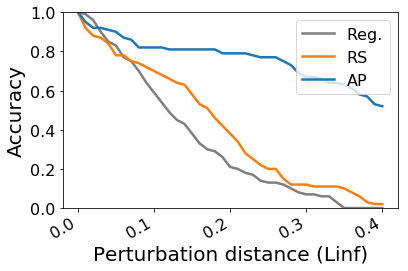

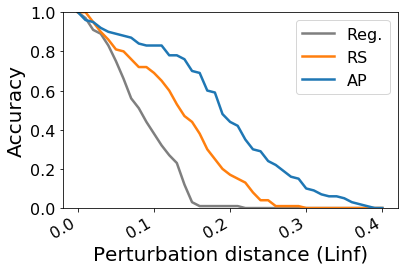

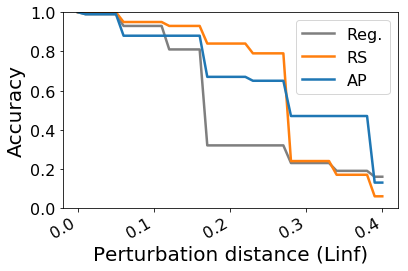

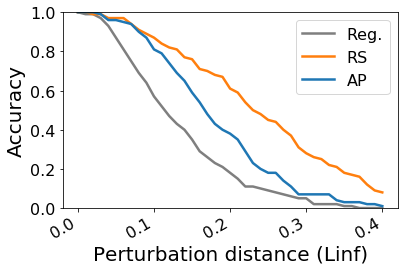

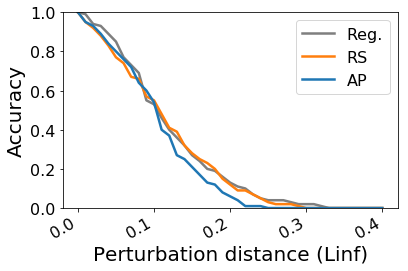

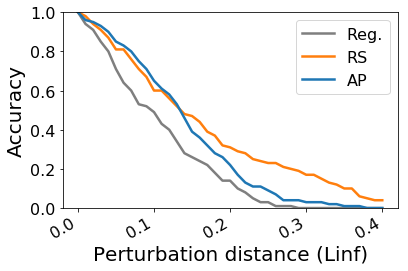

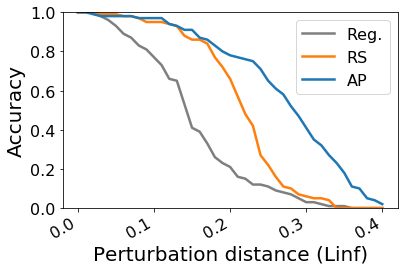

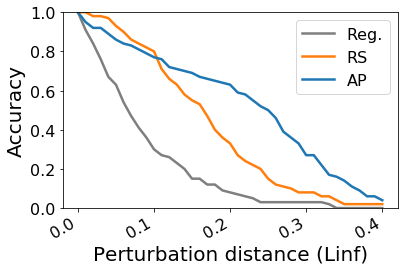

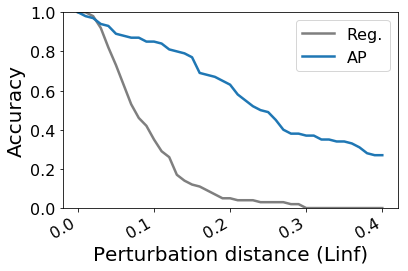

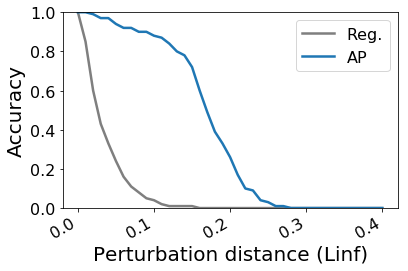

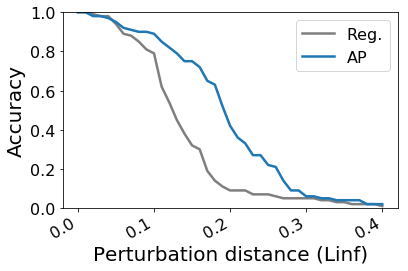

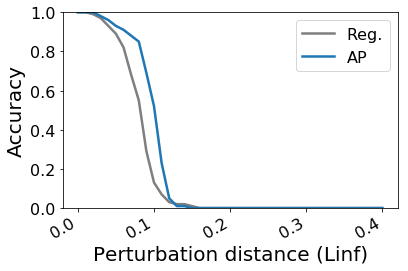

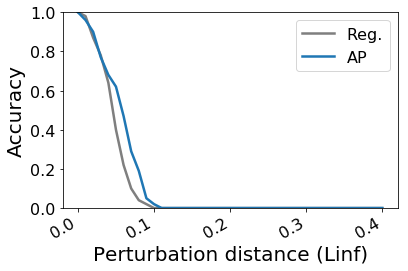

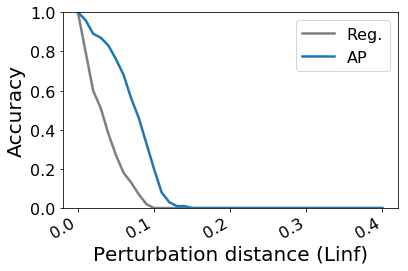

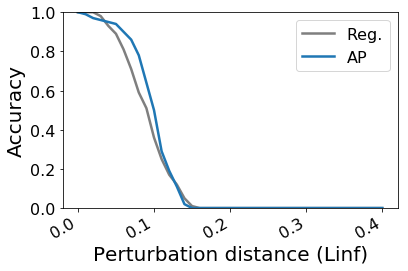

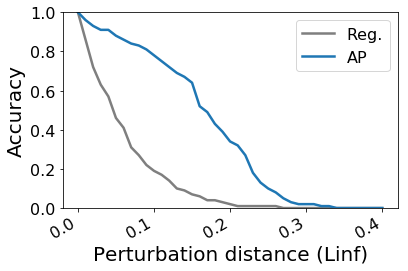

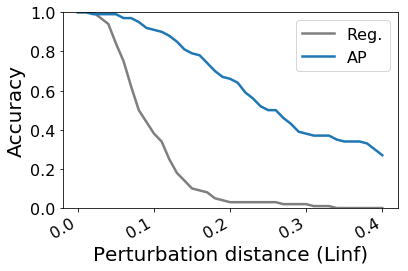

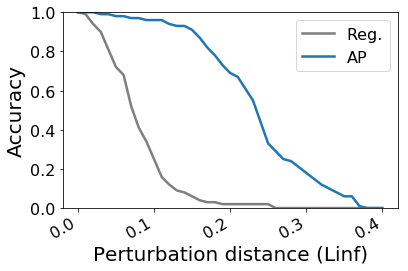

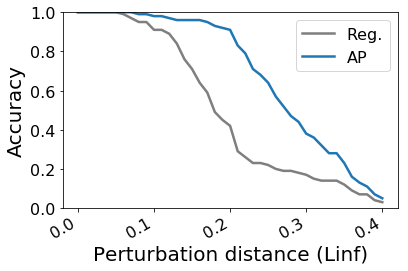

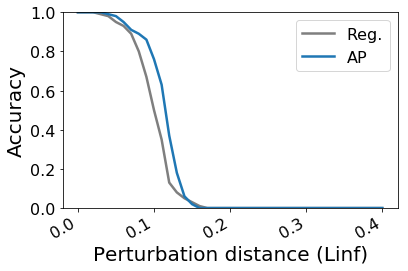

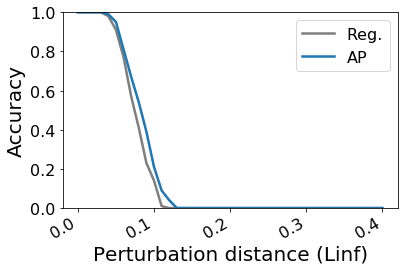

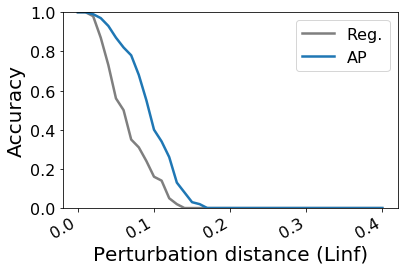

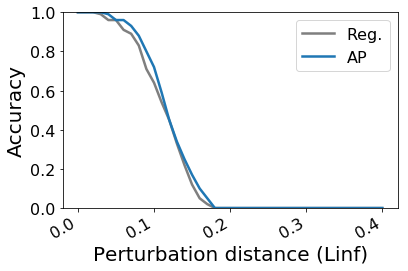

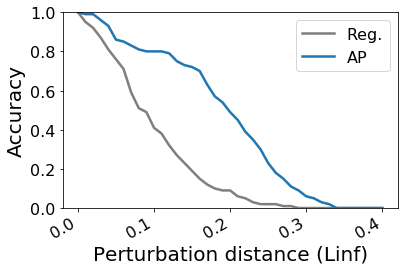

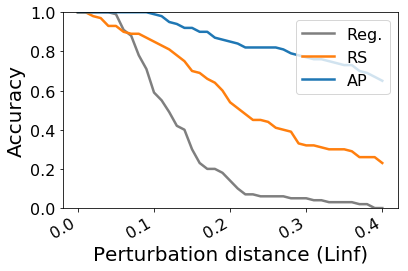

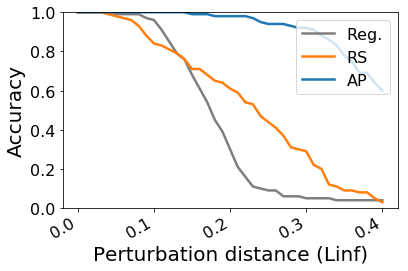

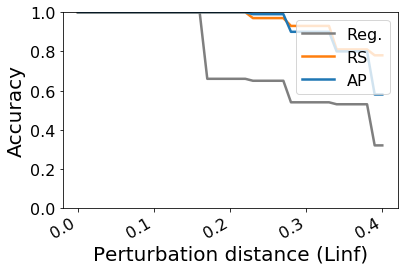

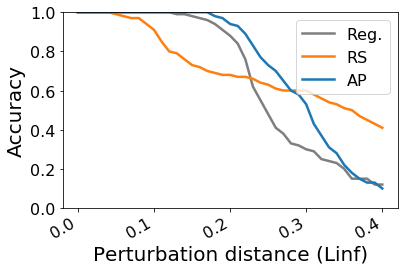

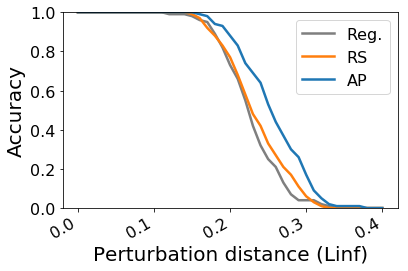

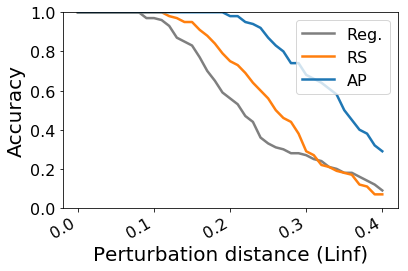

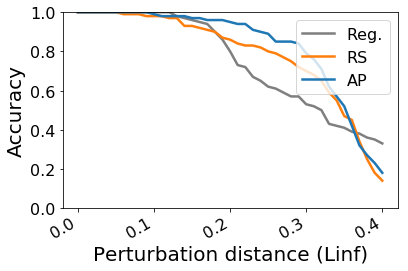

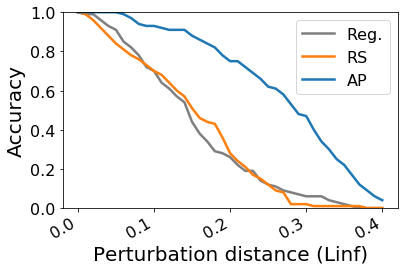

In [9]:
exp_fns = [dt_robustness_figs, nn_k1_robustness_figs, nn_k3_robustness_figs, rf_robustness_figs]
def get_label_name(name):
    if 'robustv1' in name:
        return "AP"
    elif 'robust' in name:
        return "RS"
    elif 'decision_tree' in name:
        return "Reg."
    elif 'knn1' in name:
        return "Reg."
    elif 'knn3' in name:
        return "Reg."
    elif 'random_forest' in name:
        return "Reg."
        
    return name

def get_label_color(name):
    if 'robustv1' in name:
        return "#1f77b4"
    elif 'robust' in name:
        return "#ff7f0e"
    elif 'decision_tree' in name:
        return "#7f7f7f"
    elif 'knn1' in name:
        return "#7f7f7f"
    elif 'knn3' in name:
        return "#7f7f7f"
    elif 'random_forest' in name:
        return "#7f7f7f"
        
    return name

def compare_nn_plots(exp_name, grid_param, caption='', show_plot=True):
    df = params_to_dataframe(grid_param)
    datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']

    control = {
        'dataset': datasets,
        'ord': grid_param['ord'],
    }
    variables = ['model']
    
    plot_result(df, exp_name, control, variables,
                get_title=lambda x: '',
                get_label_name=get_label_name,
                get_label_color=get_label_color,
                show_plot=show_plot)
    return result_latex_figs(exp_name, control, caption)

for fn in exp_fns:
    _, exp_name, grid_param, _ = fn()
    fig_str = compare_nn_plots(exp_name, grid_param, show_plot=True)
#write_to_tex(fig_str, exp_name + '_fig.tex')

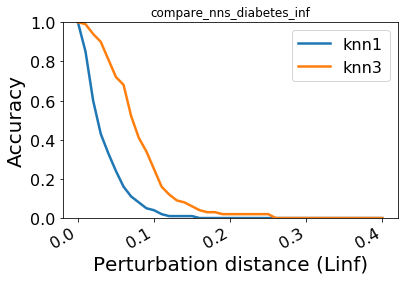

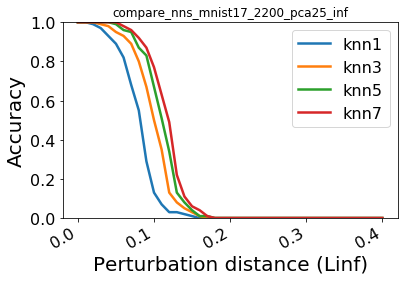

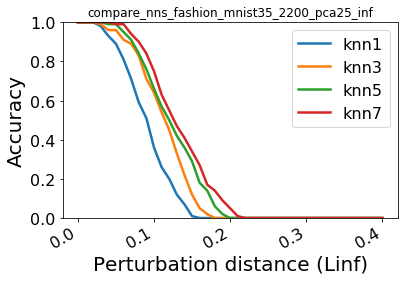

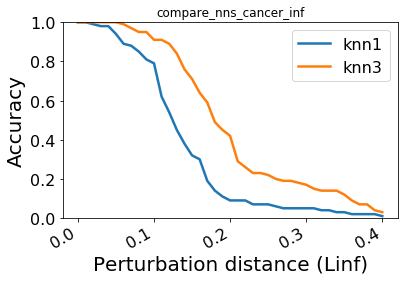

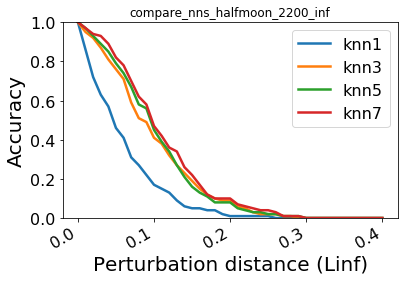

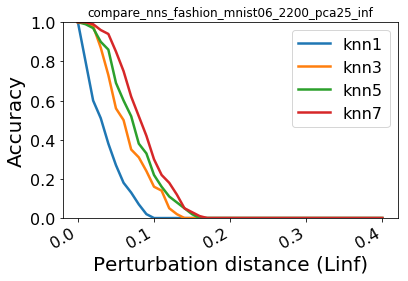

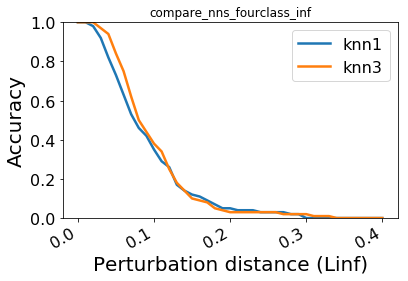

In [10]:
_, exp_name, grid_param, _ = compare_nns()

def compare_nn_plots(exp_name, grid_param, caption='', show_plot=True):
    df = params_to_dataframe(grid_param)
    datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']

    control = {
        'dataset': datasets,
        'ord': grid_param[0]['ord'],
    }
    variables = ['model']
    plot_result(df, exp_name, control, variables, show_plot=show_plot)
    return result_latex_figs(exp_name, control, caption)
fig_str = compare_nn_plots(exp_name, grid_param, show_plot=True)
write_to_tex(fig_str, exp_name + '_fig.tex')

In [13]:
%%bash
bash ./sync_report.sh

In [12]:
assert 1==0

AssertionError: 

In [ ]:
_, exp_name, grid_param, _ = nn_k1_robustness()
avg_caption = "1-NN average perturbation distance (Linf)"
table_str = table_wrapper(exp_name, grid_param, ['n_samples', 'n_features', 'model', 'attack'], ['dataset'],
                          caption=avg_caption, objs=['avg_pert'],
                          additionals=[cmp_ratio, max_imp, partial(model_acc, grid_param=grid_param)])
table_str = re.sub(r"([a-zA-Z_0-9'-]+) imp\.", "imp.", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+) tst acc\.", "tst acc.", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+)-avg-pert", r"\1", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+) \$\\epsilon\$", "$\\epsilon$", table_str)
table_str = table_str.replace("lrrlllllllllllllllllll", "lcc|lll|llll|llll|llll|llll")
table_str = table_str.replace("nnopt-k1-all", "opt")
table_str = table_str.replace("robustv1-nn-k1", "1-NN with adversarial pruning")
table_str = table_str.replace("knn1", "1-NN")
table_str = table_str.replace("blackbox", "Cheng's")
table_str = table_str.replace("multicolumn{8}{l}", "multicolumn{8}{|c}")
table_str = table_str.replace("multicolumn{3}{l}", "multicolumn{3}{|c}")
for k, v in variable_name['dataset'].items():
    table_str = re.sub(k.replace('_', '-'), v, table_str)
write_to_tex(table_str, exp_name + '_table.tex')

In [ ]:
_, exp_name, grid_param, _ = nn_k3_robustness()
avg_caption = "3-NN average perturbation distance (Linf)"
#table_str = table_wrapper(exp_name, grid_param, ['model', 'attack'], ['dataset'], caption=avg_caption, additionals=[cmp_ratio])
#table_str = re.sub("([a-zA-Z_0-9'-]*) imp\.", "imp.", table_str)
#write_to_tex(table_str, exp_name + '_table.tex')
table_str = table_wrapper(exp_name, grid_param, ['n_samples', 'n_features', 'model', 'attack'], ['dataset'], caption=avg_caption, 
                          objs=['avg_pert'],
                          additionals=[cmp_ratio, max_imp, partial(model_acc, grid_param=grid_param)])
table_str = re.sub(r"([a-zA-Z_0-9'-]+) imp\.", "imp.", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+) tst acc\.", "tst acc.", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+)-avg-pert", r"\1", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+) \$\\epsilon\$", "$\\epsilon$", table_str)
table_str = table_str.replace("lrrlllllllllllllllllll", "lcc|lll|llll|llll|llll|llll")
table_str = table_str.replace("rev-nnopt-k3-50-region", "our-50")
table_str = table_str.replace("robustv1-nn-k3", "3-NN with adversarial pruning")
table_str = table_str.replace("blackbox", "Cheng's")
table_str = table_str.replace("knn3", "3-NN")
table_str = table_str.replace("multicolumn{8}{l}", "multicolumn{8}{|c}")
table_str = table_str.replace("multicolumn{3}{l}", "multicolumn{3}{|c}")
for k, v in variable_name['dataset'].items():
    table_str = re.sub(k.replace('_', '-'), v, table_str)
write_to_tex(table_str, exp_name + '_table.tex')

In [ ]:
_, exp_name, grid_param, _ = rf_robustness()
avg_caption = "Random forest average perturbation distance (Linf)"
table_str = table_wrapper(exp_name, grid_param, ['n_samples', 'n_features', 'model', 'attack'], ['dataset'], caption=avg_caption, 
                          objs=['avg_pert'],
                          additionals=[cmp_ratio, max_imp, partial(model_acc, grid_param=grid_param)])
table_str = re.sub(r"([a-zA-Z_0-9'-]+) imp\.", "imp.", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+) tst acc\.", "tst acc.", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+)-avg-pert", r"\1", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+) \$\\epsilon\$", "$\\epsilon$", table_str)
table_str = table_str.replace("lrrlllllllllllllllllllllllllll", "lcc|lll|llll|llll|llll|llll|llll|llll")
table_str = table_str.replace("rf-attack-rev-", "our-")
table_str = table_str.replace("blackbox", "Cheng's")
table_str = table_str.replace("random-forest-100-d5", "random forest")
table_str = table_str.replace("robust-rf-100-d5", "random forest with robust splitting")
table_str = table_str.replace("robustv1-rf-100-d5", "random forest with adversarial pruning")

table_str = table_str.replace("multicolumn{8}{l}", "multicolumn{8}{|c}")
table_str = table_str.replace("multicolumn{3}{l}", "multicolumn{3}{|c}")
for k, v in variable_name['dataset'].items():
    table_str = re.sub(k.replace('_', '-'), v, table_str)
write_to_tex(table_str, exp_name + '_table.tex')

In [ ]:
_, exp_name, grid_param, _ = dt_robustness()
avg_caption = "Decision tree average perturbation distance (Linf)"
table_str = table_wrapper(exp_name, grid_param, ['model', 'attack'], ['dataset'], caption=avg_caption, 
                          objs=['avg_pert'],
                          additionals=[cmp_ratio, max_imp, partial(model_acc, grid_param=grid_param)])
table_str = re.sub(r"([a-zA-Z_0-9'-]+) imp\.", "imp.", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+) tst acc\.", "tst acc.", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+)-avg-pert", r"\1", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+) \$\\epsilon\$", "$\\epsilon$", table_str)
table_str = table_str.replace("llllllllllllllllllllllllllll", "llll|llll|llll|llll|llll|llll|llll")
table_str = table_str.replace("dt-attack-opt", "opt")
write_to_tex(table_str, exp_name + '_table.tex')

In [ ]:
_, exp_name, grid_param, _ = nn_k1_optimality_figs()
df = params_to_dataframe(grid_param, ['avg_pert'])
datasets = union_param_key(grid_param, 'dataset')
for dataset in datasets:
    temp_df = df[(df['dataset'] == dataset)]
    fig, ax = plt.subplots()
    ax.set_title(dataset)
    x = []
    for k, v in temp_df.groupby("attack"):
        avg_pert = v['avg_pert'].mean()
        if k == 'blackbox':
            bb_avg = avg_pert
            ax.hlines(avg_pert, xmin=0, xmax=100, label='Cheng', colors='c')
        elif k.split('_')[-1] == 'all':
            opt_avg = avg_pert
            ax.hlines(avg_pert, xmin=0, xmax=100, label='opt')
        elif k.split('_')[-1] == 'rev':
            x.append((100, avg_pert))
        else:
            if k.split('_')[-1] != 'region':
                x.append((int(k.split('_')[-1]), avg_pert))
            else:
                x.append((int(k.split('_')[-2]), avg_pert))
    x = sorted(x, key=lambda t: t[0])
    x, y = zip(*x)
    ax.plot(x, y)
    set_plot(fig, ax)
    ax.set_ylim(opt_avg-0.03, max(list(y) + [bb_avg])+0.03)
    ax.set_xlim(0, 100)
    #plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
    #plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.png', format='png')
    plt.show()

In [ ]:
for fn in [nn_k1_robustness_figs, nn_k3_robustness_figs]:
    _, exp_name, grid_param, _ = fn()
    df = params_to_dataframe(grid_param, ['avg_pert'])
    datasets = union_param_key(grid_param, 'dataset')
    for dataset in datasets:
        temp_df = df[(df['dataset'] == dataset)]
        fig, ax = plt.subplots()
        ax.set_title(dataset)
        x = []
        for k, v in temp_df.groupby("attack"):
            avg_pert = v['avg_pert'].mean()
            if k == 'blackbox':
                ax.hlines(avg_pert, xmin=0, xmax=50, label='Cheng')
            elif k.split('_')[-1] == 'all':
                opt_pert = avg_pert
                ax.hlines(avg_pert, xmin=0, xmax=50, label='opt')
            else:
                x.append((int(k.split('_')[-2]), avg_pert))
        x = sorted(x, key=lambda t: t[0])
        x, y = zip(*x)
        ax.plot(x, y)
        set_plot(fig, ax)
        ax.set_ylim(opt_pert-0.03, max(y)+0.03)
        ax.set_xlim(0, 50)
        #ax.set_xscale('log')
        #plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        #plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.png', format='png')
        plt.show()

In [ ]:
_, exp_name, grid_param, _ = rf_optimality()
avg_caption = "RF average perturbation distance (Linf)"
table_str = table_wrapper(exp_name, grid_param,
                          ['n_samples', 'n_features', 'n_classes', 'model', 'attack'], ['dataset'],
                          caption=avg_caption, combine_method=1)
table_str = re.sub(r"([a-zA-Z_0-9'-]+)-avg-pert", r"\1", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+)-region", r"\1", table_str)
table_str = table_str.replace("rf-attack-rev-", "our-")
write_to_tex(table_str, exp_name + '_table.tex')

In [ ]:
_, exp_name, grid_param, _ = nn_optimality()
avg_caption = "3NN average perturbation distance (Linf)"
table_str = table_wrapper(exp_name, grid_param,
                          ['n_samples', 'n_features', 'n_classes', 'model', 'attack'], ['dataset'],
                          caption=avg_caption, combine_method=1)
table_str = re.sub(r"([a-zA-Z_0-9'-]+)-avg-pert", r"\1", table_str)
table_str = re.sub(r"([a-zA-Z_0-9'-]+)-region", r"\1", table_str)
table_str = table_str.replace("nnopt-k3-", "our-")
write_to_tex(table_str, exp_name + '_table.tex')

In [ ]:
_, _, grid_param, _ = nn_k1_robustness()
datasets = union_param_key(grid_param, 'dataset')
exp_name = "dataset-stats"
grid_param = {
    "dataset": datasets,
}
caption = "Data set statistics"
table_str = table_wrapper(exp_name, grid_param, ['n_samples', 'n_features', 'n_classes'], ['dataset'], caption=caption)
write_to_tex(table_str, exp_name + '_table.tex')

In [ ]:
experiments = [rf_attack, opt_of_rf_attack, robust_rf]
avg_caption = "average purturbation distance (Linf)"
miss_caption = "\\# of data algorithms is not able to generate successful attack (total 100 data points)"
for fn in experiments:
    _, exp_name, grid_param, _ = fn()
    print(exp_name)
    #columns = ['blackbox', 'rf_attack_rev_20', 'rf_attack_rev_100']
    table_str = table_wrapper(exp_name, grid_param, ['attack'], ['dataset'], caption=avg_caption)
    write_to_tex(table_str, exp_name + '_table.tex')
    fig_str = knn_attack_plots(exp_name, grid_param, show_plot=False)
    write_to_tex(fig_str, exp_name + '_fig.tex')

In [ ]:
nn_experiments = [nn_k1, nn_k3, nn_k5, nn_k7, opt_of_nnopt]
avg_caption = "average purturbation distance (Linf)"
miss_caption = "\\# of data algorithms is not able to generate successful attack (total 100 data points)"
for fn in nn_experiments:
    _, exp_name, grid_param, _ = fn()
    print(grid_param)
    variables = grid_param[0]['attack']
    #variables = list(filter(lambda v: 'kernelsub' not in v and 'direct' not in v, variables))
    variables = list(filter(lambda v: 'kernelsub' not in v, variables))
    print(variables)
    table_str = table_wrapper(exp_name, grid_param, variables, caption=avg_caption)
    table_str += table_wrapper(exp_name, grid_param, variables, obj='missed_count', caption=miss_caption)
    #print(table_str)
    write_to_tex(table_str, exp_name + '_table.tex')

In [ ]:
nn_experiments = [nn_k1, nn_k3, nn_k5, nn_k7, opt_of_nnopt]
for fn in nn_experiments:
    _, exp_name, grid_param, _ = fn()
    print(exp_name)
    fig_str = knn_attack_plots(exp_name, grid_param, show_plot=False)
    write_to_tex(fig_str, exp_name + '_fig.tex')

In [ ]:
nn_experiments = [robust_nn_k1, robust_nn_k3]
avg_caption = "average purturbation distance (Linf)"
miss_caption = "\\# of data algorithms is not able to generate successful attack (total 100 data points)"
for fn in nn_experiments:
    _, exp_name, grid_param, _ = fn()
    variables = grid_param[0]['attack']
    variables = list(filter(lambda v: 'kernelsub' not in v and 'direct' not in v, variables))
    print(variables)
    table_str = table_wrapper(exp_name, grid_param, variables, caption=avg_caption)
    table_str += table_wrapper(exp_name, grid_param, variables, obj='missed_count', caption=miss_caption)
    write_to_tex(table_str, exp_name + '_table.tex')

In [ ]:
nn_experiments = [robust_nn_k1, robust_nn_k3]
avg_caption = "average purturbation distance (Linf)"
miss_caption = "\\# of data algorithms is not able to generate successful attack (total 100 data points)"
for fn in nn_experiments:
    _, exp_name, grid_param, _ = fn()
    variables = grid_param[0]['attack']
    variables = list(filter(lambda v: 'kernelsub' not in v and 'direct' not in v, variables))
    print(variables)
    table_str = table_wrapper(exp_name, grid_param, variables, caption=avg_caption)
    table_str += table_wrapper(exp_name, grid_param, variables, obj='missed_count', caption=miss_caption)
    write_to_tex(table_str, exp_name + '_table.tex')

In [ ]:
from nnattack.models.robust_nn.eps_separation import build_collision_graph, find_min_cover
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=3)

auto_var.set_variable_value("random_seed", 0)
np.random.seed(0)
X, y, _ = auto_var.get_var_with_argument("dataset", "mnist17_2200")
pts = PCA().fit_transform(X)
idx = np.arange(len(X))
np.random.shuffle(idx)
pts = MinMaxScaler().fit_transform(pts)

nn.fit(pts)
y_pts = [1 if i>0 else -1 for i in y]
adj_lst, graph = build_collision_graph(0.15, pts, y_pts, np.inf)
matching, min_cover = find_min_cover(graph, adj_lst, y_pts)

In [ ]:
min_cover

In [ ]:
y[list(min_cover)]

In [ ]:
for i in min_cover:
    _, idx = nn.kneighbors([pts[i]])
    plt.imshow(X[i].reshape(28, 28))
    plt.savefig(f'/home/arbiter/figs/{i}.png', format='png')
    plt.close()
    mkdir_p(f'/home/arbiter/figs/{i}')
    for j in idx[0]:
        print(j, X.shape)
        plt.imshow(X[j].reshape(28, 28))
        plt.savefig(f'/home/arbiter/figs/{i}/{j}.png', format='png')
        plt.close()
    

In [ ]:
plt.imshow(X[0].reshape(28, 28))

In [ ]:
y